In [1]:
import pandas as pd
import numpy as np
import torch
from torch import optim
from datetime import timedelta
from torch.utils.data import DataLoader,TensorDataset
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import plotly.express as px
import plotly.graph_objects as go
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from TST import TimeSeriesTransformer
from LSTM import COVID_LSTM
from GRU import COVID_GRU

%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
from Utils import count_parameters, cumulative_to_daily, daily_to_cumulative

# Importing Dataset

In [3]:
state = 'CA'
df = pd.read_csv('us-vaccines.csv').drop(['Code'],1)
vaccines_daily = df[df['Entity']=='California']['people_vaccinated'].to_numpy().reshape(-1,1)


States to be worked on are: Northern Mariana Islands, Virgin Islands, Guam

Texas	, California, New York

Virginia

# Preprocessing Data

In [7]:
scaler = MinMaxScaler(feature_range=(-1.0,+1.0))
vaccines_cumulative_normalized = scaler.fit_transform(vaccines_daily)

In [8]:
def convert_to_slide_window(data,time_steps):
    X, y = [], []
    # Stride = 1
    # The (y) in our case is just the next timestep to compare with it
    for i in range(len(data) - time_steps):
        x = data[i:(i+time_steps)]
        X.append(x)
        y.append(data[i+time_steps])
    return X,y

In [9]:
window_size = 30

X,Y = convert_to_slide_window(vaccines_cumulative_normalized,window_size)
split = int(len(X) * 0.7)

X_train,y_train=X[:split],Y[:split]
X_test,y_test =X[split:],Y[split:]

# Cumulative + Non-Normalized
X_train, y_train = torch.FloatTensor(X_train).to(device), torch.FloatTensor(y_train).to(device)
X_test, y_test  = torch.FloatTensor(X_test).to(device), torch.FloatTensor(y_test).to(device)

# Load into DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train),batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False)

# Cumulative + Non-Normalized
y_test_inverse = scaler.inverse_transform(y_test.cpu().detach().numpy())
y_train_inverse = scaler.inverse_transform(y_train.cpu().detach().numpy())

# Non-Cumulative + Non-Normalized
y_test_daily_vaccines = cumulative_to_daily(y_test_inverse)


In [10]:
y_test_inverse.shape

(25, 1)

# TST Model

In [11]:
TST_model = TimeSeriesTransformer(n_features=1,d_model=512, n_heads=8, n_hidden=512, n_layers=8 ).to(device)
criterion=torch.nn.MSELoss()
# 0.00001 is the best LR for TST
optimizer = optim.Adam(TST_model.parameters(), lr=0.00001)
all_epochs_loss = TST_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(TST_model.state_dict(), 'Weights/model_TST_{}_Vaccine'.format(state))
# TST_model.load_state_dict(torch.load('Weights/model_TST_{}_Vaccine'.format(state)))

Epoch 1 Loss is 0.2822604328393936
Epoch 2 Loss is 0.11188112571835518
Epoch 3 Loss is 0.0839991495013237
Epoch 4 Loss is 0.08521527424454689
Epoch 5 Loss is 0.07587022706866264
Epoch 6 Loss is 0.059004055336117744
Epoch 7 Loss is 0.05156850814819336
Epoch 8 Loss is 0.044535448774695396
Epoch 9 Loss is 0.04271568916738033
Epoch 10 Loss is 0.03493733797222376
Epoch 11 Loss is 0.03208218980580568
Epoch 12 Loss is 0.026435600593686104
Epoch 13 Loss is 0.01538309920579195
Epoch 14 Loss is 0.01687151100486517
Epoch 15 Loss is 0.01522074150852859
Epoch 16 Loss is 0.03249026369303465
Epoch 17 Loss is 0.012907903525047004
Epoch 18 Loss is 0.08772088587284088
Epoch 19 Loss is 0.072773901745677
Epoch 20 Loss is 0.004798983572982252
Epoch 21 Loss is 0.004922285443171859
Epoch 22 Loss is 0.003635971574112773
Epoch 23 Loss is 0.004380615602713078
Epoch 24 Loss is 0.005602594697847962
Epoch 25 Loss is 0.005221126019023359
Epoch 26 Loss is 0.004231501778122038
Epoch 27 Loss is 0.003896122449077666
Ep

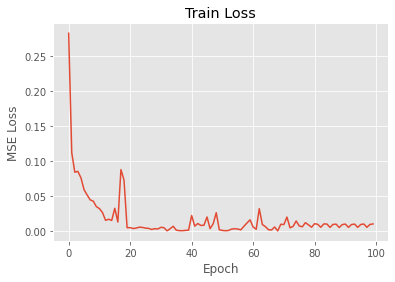

In [12]:
# Epoch 300 Loss is 0.0021550819316568473
fig, ax = plt.subplots()
plt.plot(all_epochs_loss)

ax.set_title('Train Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
plt.show()

In [13]:
def test_TST(model, X):
    model.eval()
    torch.cuda.empty_cache()
    S = X.shape[1] # Sequence Length
    src_mask = model.generate_square_subsequent_mask(S)
    predicted = model(X.permute(1,0,2),None,None).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[-1,:,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('TST: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps
forecasted_TST = test_TST(TST_model, X=X_test)

TST: Test MSE Loss:  0.005685179028660059


In [14]:
X_train[-1].shape

torch.Size([30, 1])

In [15]:
def forecast_TST(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(1) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,],None,None).to(device) # [S,B,E] 
        one_new_timestep=predicted[-1,:,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),0)  # add the forecasted timestep
        
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_TST = forecast_TST(TST_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size )

Test MSE Loss:  tensor(0.0308, device='cuda:0', grad_fn=<MseLossBackward>)


/rhome/yelnady/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([25, 1])) that is different to the input size (torch.Size([25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [16]:
print("We used {} Parameters for the transformer model".format(count_parameters(TST_model)))

We used 12625409 Parameters for the transformer model


In [17]:
forecasted_inverse_TST = scaler.inverse_transform(forecasted_TST.cpu().detach().numpy())
forecasted_daily_vaccines_TST  = cumulative_to_daily(forecasted_inverse_TST)

In [18]:
print('R2 Score for Vaccines',r2_score(y_test.cpu().detach().numpy(),forecasted_TST.cpu().detach().numpy()))
print('MAPE Score for Vaccines',mean_absolute_percentage_error(y_test.cpu().detach().numpy(),forecasted_TST.cpu().detach().numpy()))

R2 Score for Vaccines 0.7087719984147376
MAPE Score for Vaccines 0.07358544


# LSTM Model

In [19]:
LSTM_model = COVID_LSTM(n_hidden=256,n_features=1).to(device)
criterion=torch.nn.MSELoss()
optimizer = optim.Adam(LSTM_model.parameters(), lr=0.0001)
all_epochs_loss = LSTM_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(LSTM_model.state_dict(), 'Weights/model_LSTM_{}_Vaccine'.format(state))
# LSTM_model.load_state_dict(torch.load('Weights/model_LSTM_{}_Vaccine'.format(state)))

Epoch 1 Loss is 0.13013900071382523
Epoch 2 Loss is 0.12397860735654831
Epoch 3 Loss is 0.12133324891328812
Epoch 4 Loss is 0.11609480530023575
Epoch 5 Loss is 0.11401767283678055
Epoch 6 Loss is 0.11019739136099815
Epoch 7 Loss is 0.10620441287755966
Epoch 8 Loss is 0.10605032369494438
Epoch 9 Loss is 0.10557971522212029
Epoch 10 Loss is 0.1063617542386055
Epoch 11 Loss is 0.10448795929551125
Epoch 12 Loss is 0.10496369749307632
Epoch 13 Loss is 0.10350850224494934
Epoch 14 Loss is 0.1025320515036583
Epoch 15 Loss is 0.10142558813095093
Epoch 16 Loss is 0.10213002935051918
Epoch 17 Loss is 0.09707155078649521
Epoch 18 Loss is 0.09623816981911659
Epoch 19 Loss is 0.09235372394323349
Epoch 20 Loss is 0.08979767188429832
Epoch 21 Loss is 0.09231269359588623
Epoch 22 Loss is 0.08757977560162544
Epoch 23 Loss is 0.08191150426864624
Epoch 24 Loss is 0.07985065132379532
Epoch 25 Loss is 0.0715346708893776
Epoch 26 Loss is 0.061528393998742104
Epoch 27 Loss is 0.05421104282140732
Epoch 28 Los

In [20]:
def test_LSTM(model, X):
    model.eval()
    torch.cuda.empty_cache()
    predicted = model(X).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[:,-1,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('LSTM: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps

forecasted_LSTM = test_LSTM(LSTM_model, X=X_test)

LSTM: Test MSE Loss:  0.014089690521359444


In [21]:
X_test.shape

torch.Size([25, 30, 1])

In [22]:
def forecast_LSTM(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(0) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,]).to(device) # [B,S,E] 
        
        one_new_timestep=predicted[:,-1,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),1)  # add the forecasted timestep
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_LSTM = forecast_LSTM(LSTM_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size )

Test MSE Loss:  tensor(0.0408, device='cuda:0', grad_fn=<MseLossBackward>)


/rhome/yelnady/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([25, 1])) that is different to the input size (torch.Size([25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [23]:
forecasted_inverse_LSTM = scaler.inverse_transform(forecasted_LSTM.cpu().detach().numpy())
forecasted_daily_vaccines_LSTM  = cumulative_to_daily(forecasted_inverse_LSTM)

In [24]:
print('R2 Score for Vaccines',r2_score(y_test_daily_vaccines,forecasted_daily_vaccines_LSTM))
print('MAPE Score for Vaccines',mean_absolute_percentage_error(y_test_daily_vaccines,forecasted_daily_vaccines_LSTM))

R2 Score for Vaccines 0.9990633418006578
MAPE Score for Vaccines 0.35153034


# GRU Model

In [25]:
GRU_model = COVID_GRU(n_hidden=256,n_features=1).to(device)
criterion=torch.nn.MSELoss()
optimizer = optim.Adam(GRU_model.parameters(), lr=0.0001)
all_epochs_loss = GRU_model.train_model(train_loader,criterion,optimizer,n_epochs = 100 )
torch.save(GRU_model.state_dict(), 'Weights/model_GRU_{}_Vaccine'.format(state))
# GRU_model.load_state_dict(torch.load('Weights/model_GRU_{}_Vaccine'.format(state)))

Epoch 1 Loss is 0.12233255431056023
Epoch 2 Loss is 0.11248330026865005
Epoch 3 Loss is 0.10774556547403336
Epoch 4 Loss is 0.1017041765153408
Epoch 5 Loss is 0.09568113461136818
Epoch 6 Loss is 0.09413935616612434
Epoch 7 Loss is 0.0926109217107296
Epoch 8 Loss is 0.08599337562918663
Epoch 9 Loss is 0.07934900559484959
Epoch 10 Loss is 0.07511017471551895
Epoch 11 Loss is 0.06892829015851021
Epoch 12 Loss is 0.06289505213499069
Epoch 13 Loss is 0.054281484335660934
Epoch 14 Loss is 0.04594947397708893
Epoch 15 Loss is 0.036600569263100624
Epoch 16 Loss is 0.026402469724416733
Epoch 17 Loss is 0.016432348638772964
Epoch 18 Loss is 0.007790659787133336
Epoch 19 Loss is 0.0018010627245530486
Epoch 20 Loss is 0.00044547758443513885
Epoch 21 Loss is 0.003344134718645364
Epoch 22 Loss is 0.006390727125108242
Epoch 23 Loss is 0.006775382906198502
Epoch 24 Loss is 0.005164909642189741
Epoch 25 Loss is 0.002498811110854149
Epoch 26 Loss is 0.0007192534685600549
Epoch 27 Loss is 0.0002168788705

In [26]:
def test_GRU(model, X):
    model.eval()
    torch.cuda.empty_cache()
    predicted = model(X).to(device) # [Batch Size, Sequence Length, n_features = 1]
    one_new_timesteps=predicted[:,-1,:] # [Batch Size, Sequence Length (Last time step), n_features = 1] -> [Batch Size,]
    print('GRU: Test MSE Loss: ',criterion(one_new_timesteps,y_test).item())
    return one_new_timesteps

forecasted_GRU = test_GRU(GRU_model, X=X_test)

GRU: Test MSE Loss:  0.013142380863428116


In [27]:
X_test.shape

torch.Size([25, 30, 1])

In [28]:
def forecast_GRU(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(0) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint[-n_seed:,]).to(device) # [B,S,E] 
        
        one_new_timestep=predicted[:,-1,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),1)  # add the forecasted timestep
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    print('Test MSE Loss: ',criterion(forecasted,y_test))
    return forecasted

forecasted_once_GRU = forecast_GRU(GRU_model,X=X_test[0],forecast_len=len(y_test),n_seed = window_size )

Test MSE Loss:  tensor(0.0435, device='cuda:0', grad_fn=<MseLossBackward>)


/rhome/yelnady/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:528: UserWarning:

Using a target size (torch.Size([25, 1])) that is different to the input size (torch.Size([25])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [29]:
forecasted_inverse_GRU = scaler.inverse_transform(forecasted_GRU.cpu().detach().numpy())
forecasted_daily_vaccines_GRU  = cumulative_to_daily(forecasted_inverse_GRU)

In [30]:
print('R2 Score for Vaccines',r2_score(y_test_daily_vaccines,forecasted_daily_vaccines_GRU))
print('MAPE Score for Vaccines',mean_absolute_percentage_error(y_test_daily_vaccines,forecasted_daily_vaccines_GRU))

R2 Score for Vaccines 0.9990667986197543
MAPE Score for Vaccines 0.35641566


# Plots

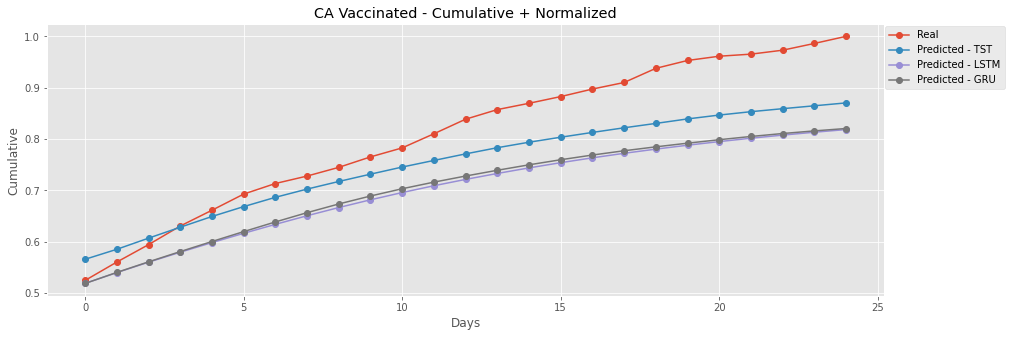

In [31]:
fig, ax = plt.subplots()
# ax.set_ylim([0.0,1.1])

plt.plot(y_test[:,0].cpu().detach().numpy(),label='Real',marker='o')
plt.plot(forecasted_TST[:,0].cpu().detach().numpy(),label='Predicted - TST',marker='o')
plt.plot(forecasted_LSTM[:,0].cpu().detach().numpy(),label='Predicted - LSTM',marker='o')
plt.plot(forecasted_GRU[:,0].cpu().detach().numpy(),label='Predicted - GRU',marker='o')

# plt.plot(forecasted_once_TST[:,0].cpu().detach().numpy(),label='Forecast Function - TST',marker='o')
fig.set_size_inches(15, 5)
ax.set_title('{} Vaccinated - Cumulative + Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()

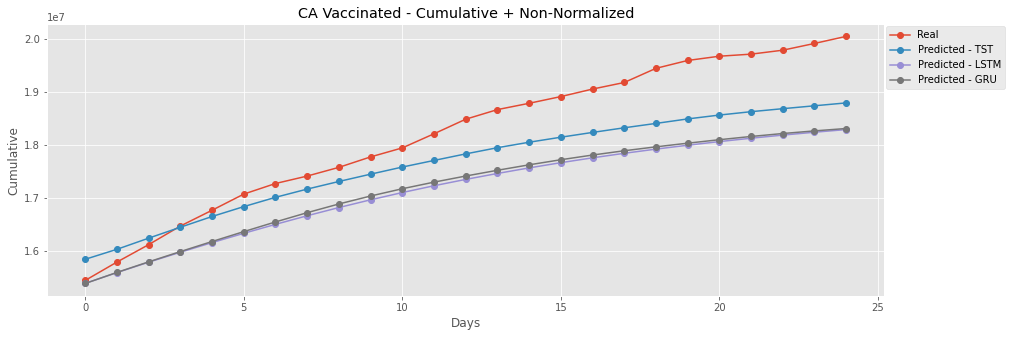

In [32]:
fig, ax = plt.subplots()

plt.plot(y_test_inverse[:,0],label='Real',marker='o')
plt.plot(forecasted_inverse_TST[:,0],label='Predicted - TST',marker='o')
plt.plot(forecasted_inverse_LSTM[:,0],label='Predicted - LSTM',marker='o')
plt.plot(forecasted_inverse_GRU[:,0],label='Predicted - GRU',marker='o')

fig.set_size_inches(15, 5)
ax.set_title('{} Vaccinated - Cumulative + Non-Normalized'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative')
leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()